In [1]:
cd ../deepsalience/

/scratch/rmb456/multif0/deepsalience


In [2]:
from __future__ import print_function

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import librosa
import mir_eval
import numpy as np

import keras
from keras.models import Model
from keras.layers import Dense, Input, Reshape, Lambda
from keras.layers.merge import Concatenate
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import os

import compute_training_data as C
import experiment_datasets
import evaluate
import core

Using TensorFlow backend.


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9383966335267033980
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 7969613415
locality {
  bus_id: 2
}
incarnation: 2918259837361751727
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:88:00.0"
]


/home/rmb456/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def add_note(f, t, n_t, decay):
    X = np.zeros((360, 50, 6))
    Y = np.zeros((360, 50))
    
    Y[f, t: t + n_t] = 1
    
    k_vals = [0, 60, 90, 120, 140, 155]
    h_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    for j in range(0, 6):
        f_j = f - k_vals[j]
        for k in range(0, 6): 
            fidx = f_j + k_vals[k]
            if fidx >= 0 and fidx < 360:
                X[fidx, t: t + n_t, j] = decay**h_vals[k]

    return X, Y


def mute_node(prob_true):
    return np.random.choice([True, False], p=[prob_true, 1.0 - prob_true])


def make_fake_data():
    noise_floor = np.random.uniform(0, 0.5)
    
    X = np.random.uniform(low=0.0, high=noise_floor, size=(360, 50, 6))
    
    # transients
    for i in range(np.random.choice(range(4))):
        t = np.random.choice(range(5, 45))
        w = np.random.choice(range(0, 3))
        X[:, t-w:t+w, :] += np.random.uniform(low=0.1, high=1.0, size=(360, 2*w, 6))
    
    
    Y_multif0 = np.zeros((360, 50))
    Y_mel = np.zeros((360, 50))
    Y_bass = np.zeros((360, 50))
    Y_piano = np.zeros((360, 50))

    freq_range = np.arange(360)
    freq_p = np.zeros(freq_range.shape)
    mel_freq_p = np.zeros(freq_range.shape)
    bass_freq_p = np.zeros(freq_range.shape)
    freq_p[::5] = 1
    freq_p[1::5] = 0.5
    freq_p[4::5] = 0.5
    freq_p[2::5] = 0.1
    freq_p[3::5] = 0.1
    mel_freq_p[:] = freq_p
    bass_freq_p[:] = freq_p
    mel_freq_p[100:300] += 2
    bass_freq_p[:80] +=2
    freq_p = freq_p/np.sum(freq_p)
    mel_freq_p = mel_freq_p/np.sum(mel_freq_p)
    bass_freq_p = bass_freq_p/np.sum(bass_freq_p)

    time_len = range(5, 50)
    
    # extra multif0 info
    for i in range(np.random.choice(range(10))):
        f = np.random.choice(freq_range, p=freq_p)
        n_t = np.random.choice(time_len)
        t = np.random.choice(range(50 - n_t))
        decay = np.random.uniform(0.2, 0.6)
        
        X_note, Y_note = add_note(f, t, n_t, decay)
        X += X_note
        Y_multif0 += Y_note
    
    # piano info
    for i in range(np.random.choice(range(5))):
        f = np.random.choice(freq_range, p=freq_p)
        n_t = np.random.choice(time_len)
        t = np.random.choice(range(50 - n_t))
        X_note, Y_note = add_note(f, t, n_t, 0.7)
        
        X += X_note
        Y_piano += Y_note
        Y_multif0 += Y_note
            
    # melody
    for i in range(np.random.choice(range(3))):
        f = np.random.choice(freq_range, p=mel_freq_p)
        n_t = np.random.choice(time_len)
        t = np.random.choice(range(50 - n_t))
        
        X_note, Y_note = add_note(f, t, n_t, 0.9)
        
        X += X_note
        Y_mel += Y_note
        Y_multif0 += Y_note
    
    # bass
    for i in range(np.random.choice(range(3))):
        f = np.random.choice(freq_range, p=bass_freq_p)
        n_t = np.random.choice(time_len)
        t = np.random.choice(range(50 - n_t))
        X_note, Y_note = add_note(f, t, n_t, 0.5)
        
        X += X_note
        Y_bass += Y_note
        Y_multif0 += Y_note
           
    X = X/np.max(X)
    Y_multif0[Y_multif0 > 0] = 1
    Y_mel[Y_mel > 0] = 1
    Y_bass[Y_bass > 0] = 1
    Y_piano[Y_piano > 0] = 1

    X = X[np.newaxis, :, :, :]
    Y_multif0 = Y_multif0[np.newaxis, :, :]
    Y_mel = Y_mel[np.newaxis, :, :]
    Y_bass = Y_bass[np.newaxis, :, :]
    Y_piano = Y_piano[np.newaxis, :, :]

    weight_shape = (1, )
    weights = {}

    if mute_node(0.5):
        weights['multif0'] = np.zeros(weight_shape) + 0.0001
    else:
        weights['multif0'] = np.ones(weight_shape)
    
    if mute_node(0.6):
        weights['melody'] = np.zeros(weight_shape) + 0.0001
    else:
        weights['melody'] = np.ones(weight_shape)
    
    if mute_node(0.3):
        weights['bass'] = np.zeros(weight_shape) + 0.0001
    else:
        weights['bass'] = np.ones(weight_shape)
    
    if mute_node(0.8):
        weights['piano'] = np.zeros(weight_shape) + 0.0001
    else:
        weights['piano'] = np.ones(weight_shape)


    return (X, {'multif0': Y_multif0, 'melody': Y_mel, 'bass': Y_bass, 'piano': Y_piano}, weights)

In [4]:
X, Y, w = make_fake_data()
Y_multif0 = Y['multif0'][0]
Y_mel = Y['melody'][0]
Y_bass = Y['bass'][0]
Y_piano = Y['piano'][0]

(-0.5, 49.5, -0.5, 359.5)

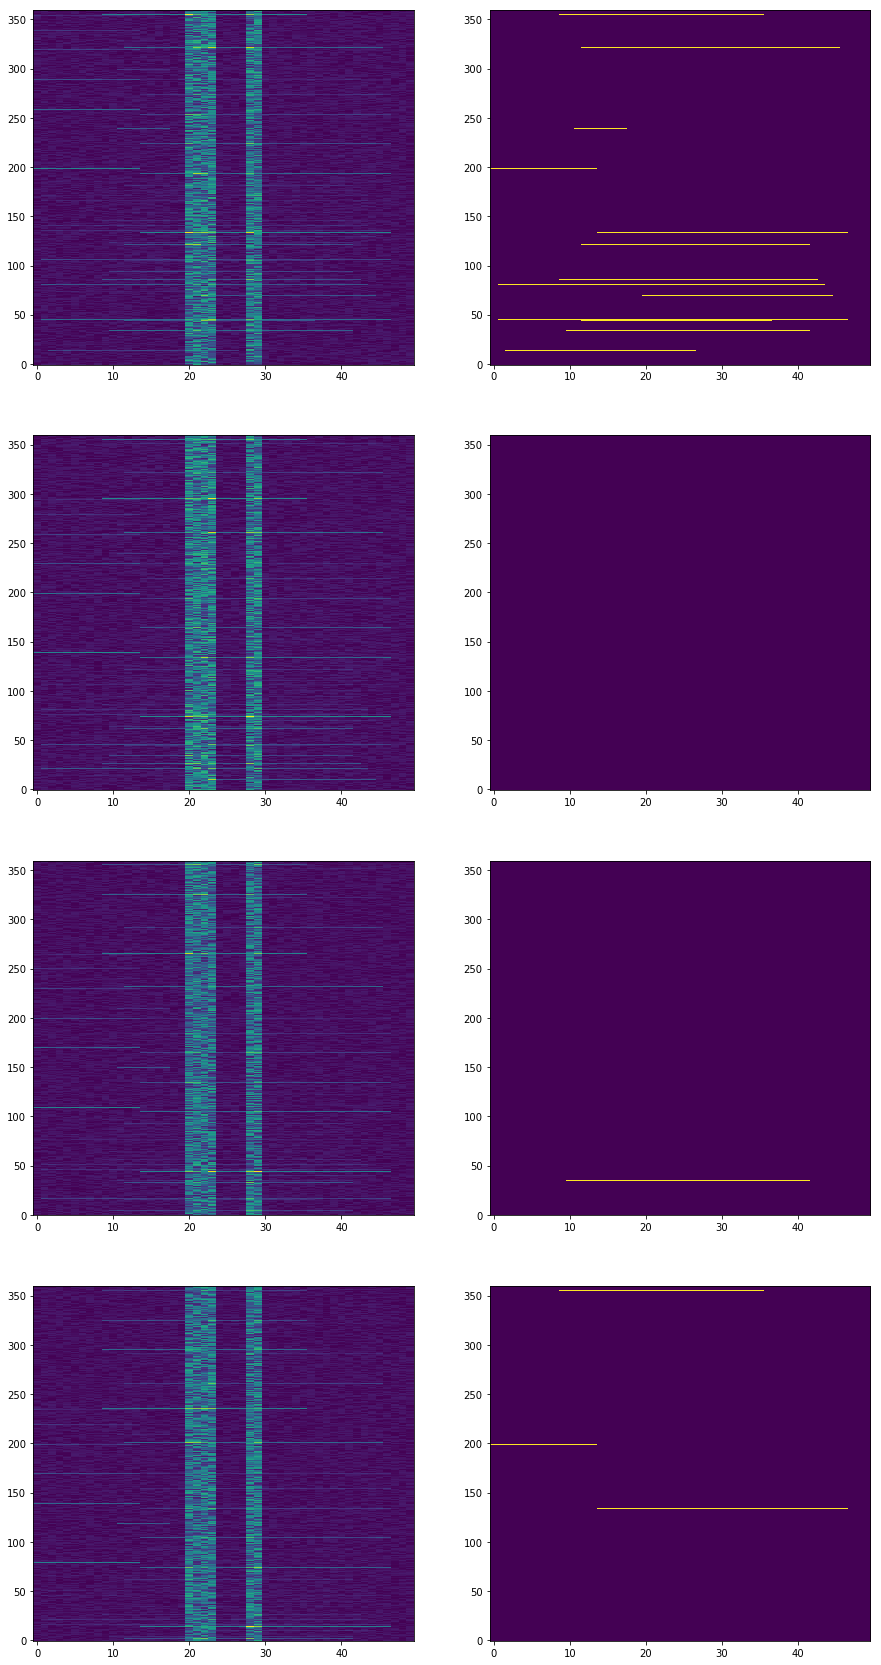

In [5]:
plt.figure(figsize=(15, 30))

plt.subplot(4, 2, 1)
plt.imshow(X[0, :, :, 0], origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 3)
plt.imshow(X[0, :, :, 1], origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 5)
plt.imshow(X[0, :, :, 2], origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 7)
plt.imshow(X[0, :, :, 3], origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 2)
plt.imshow(Y_multif0, origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 4)
plt.imshow(Y_mel, origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 6)
plt.imshow(Y_bass, origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 8)
plt.imshow(Y_piano, origin='lower')
plt.axis('auto')

In [6]:
def data_generator():
    while True:
        yield make_fake_data()

In [60]:
input_shape = (None, None, 6)
inputs = Input(shape=input_shape)

y0 = BatchNormalization()(inputs)

y1_pitch = Conv2D(
    128, (5, 5), padding='same', activation='relu', name='pitch_layer1')(y0)
y1a_pitch = BatchNormalization()(y1_pitch)
y2_pitch = Conv2D(
    32, (5, 5), padding='same', activation='relu', name='pitch_layer2')(y1a_pitch)
y2a_pitch = BatchNormalization()(y2_pitch)
y3_pitch = Conv2D(
    32, (5, 5), padding='same', activation='relu', name='pitch_layer3')(y2a_pitch)
y3a_pitch = BatchNormalization()(y3_pitch)
y4_pitch = Conv2D(
    8, (70, 3), padding='same', activation='relu', name='pitch_layer4')(y3a_pitch)
y4a_pitch = BatchNormalization()(y4_pitch)
y5_pitch = Conv2D(
    32, (5, 5), padding='same', activation='relu', name='pitch_layer5')(y4a_pitch)
y5a_pitch = BatchNormalization()(y5_pitch)


y1_timbre = Conv2D(
    128, (5, 5), padding='same', activation='relu', name='timbre_layer1')(y0)
y1a_timbre = BatchNormalization()(y1_timbre)
# y2_timbre = Conv2D(
#     32, (5, 5), padding='same', activation='relu', name='timbre_layer2')(y1a_timbre)
# y2a_timbre = BatchNormalization()(y2_timbre)

y_multif0 = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='multif0_presqueeze')(y5a_pitch)
multif0 = Lambda(lambda x: K.squeeze(x, axis=3), name='multif0')(y_multif0)

y_concat = Concatenate()([y_multif0, y1a_timbre])


y_mel_feat = Conv2D(
    32, (5, 5), padding='same', activation='relu', name='melody_filters')(y_concat)
y_mel_feat2 = Conv2D(
    1, (360, 1), padding='same', activation='relu', name='melody_filters2')(y_mel_feat)
y_bass_feat = Conv2D(
    32, (5, 5), padding='same', activation='relu', name='bass_filters')(y_concat)
y_bass_feat2 = Conv2D(
    1, (360, 1), padding='same', activation='relu', name='bass_filters2')(y_bass_feat)
y_piano_feat = Conv2D(
    32, (5, 5), padding='same', activation='relu', name='piano_filters')(y_concat)
y_piano_feat2 = Conv2D(
    1, (360, 1), padding='same', activation='relu', name='piano_filters2')(y_piano_feat)

y_melody = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='melody_presqueeze')(y_mel_feat2)
melody = Lambda(lambda x: K.squeeze(x, axis=3), name='melody')(y_melody)

y_bass = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='bass_presqueeze')(y_bass_feat2)
bass = Lambda(lambda x: K.squeeze(x, axis=3), name='bass')(y_bass)

y_piano = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='piano_presqueeze')(y_piano_feat2)
piano = Lambda(lambda x: K.squeeze(x, axis=3), name='piano')(y_piano)

model = Model(inputs=inputs, outputs=[multif0, melody, bass, piano])

In [61]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, None, None, 6) 0                                            
____________________________________________________________________________________________________
batch_normalization_27 (BatchNor (None, None, None, 6) 24                                           
____________________________________________________________________________________________________
pitch_layer1 (Conv2D)            (None, None, None, 12 19328                                        
____________________________________________________________________________________________________
batch_normalization_28 (BatchNor (None, None, None, 12 512                                          
___________________________________________________________________________________________

In [62]:
def bkld(y_true, y_pred):
    """Brian's KL Divergence implementation
    """
    y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return K.mean(K.mean(
        -1.0*y_true* K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred),
        axis=-1), axis=-1)

In [63]:
model.compile(
    loss=bkld, metrics=['mse', core.soft_binary_accuracy],
    optimizer='adam', sample_weight_mode={'multif0': None, 'melody': None, 'bass': None, 'piano': None}
)

In [64]:
train_generator = data_generator()
validation_generator = data_generator()

In [ ]:
SAMPLES_PER_EPOCH = 128
NB_EPOCHS = 40
NB_VAL_SAMPLES = 50

history = model.fit_generator(
    train_generator, SAMPLES_PER_EPOCH, epochs=NB_EPOCHS, verbose=1,
    validation_data=validation_generator, validation_steps=NB_VAL_SAMPLES,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "../outputs/multitask_test.pkl", save_best_only=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
        keras.callbacks.EarlyStopping(patience=25, verbose=0)
    ]
)

Epoch 1/40
128/128 [==============================] - 13s - loss: 0.7232 - multif0_loss: 0.2572 - melody_loss: 0.0037 - bass_loss: 0.4550 - piano_loss: 0.0073 - multif0_mean_squared_error: 0.1814 - multif0_soft_binary_accuracy: 0.8644 - melody_mean_squared_error: 0.0030 - melody_soft_binary_accuracy: 0.9986 - bass_mean_squared_error: 0.2382 - bass_soft_binary_accuracy: 0.9947 - piano_mean_squared_error: 0.0068 - piano_soft_binary_accuracy: 0.9970 - val_loss: 0.6858 - val_multif0_loss: 0.2019 - val_melody_loss: 0.0030 - val_bass_loss: 0.4755 - val_piano_loss: 0.0054 - val_multif0_mean_squared_error: 0.1186 - val_multif0_soft_binary_accuracy: 0.9869 - val_melody_mean_squared_error: 0.0012 - val_melody_soft_binary_accuracy: 0.9983 - val_bass_mean_squared_error: 0.2247 - val_bass_soft_binary_accuracy: 0.9982 - val_piano_mean_squared_error: 0.0059 - val_piano_soft_binary_accuracy: 0.9970
Epoch 2/40
128/128 [==============================] - 10s - loss: 0.5376 - multif0_loss: 0.1383 - melody

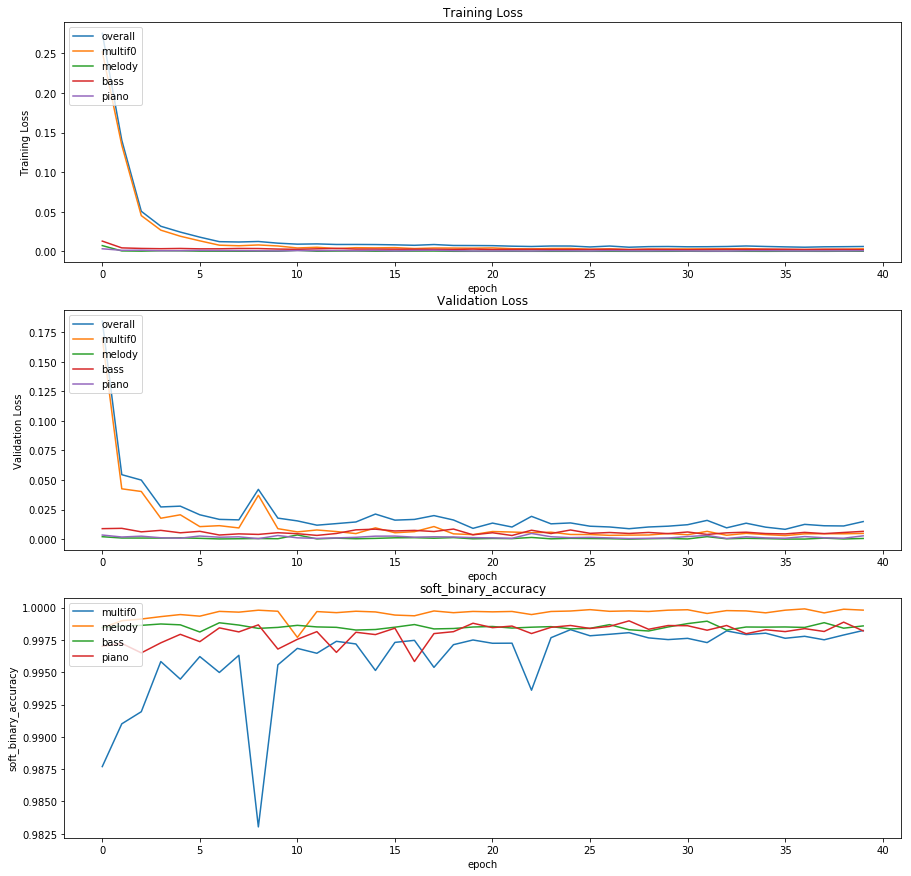

In [54]:
"""create and save plot of loss and metrics across epochs
"""
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['multif0_loss'])
plt.plot(history.history['melody_loss'])
plt.plot(history.history['bass_loss'])
plt.plot(history.history['piano_loss'])
plt.title('Training Loss')
plt.ylabel('Training Loss')
plt.xlabel('epoch')
plt.legend(['overall', 'multif0', 'melody', 'bass', 'piano'], loc='upper left')

plt.subplot(3, 1, 2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_multif0_loss'])
plt.plot(history.history['val_melody_loss'])
plt.plot(history.history['val_bass_loss'])
plt.plot(history.history['val_piano_loss'])
plt.title('Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('epoch')
plt.legend(['overall', 'multif0', 'melody', 'bass', 'piano'], loc='upper left')

plt.subplot(3, 1, 3)
# plt.plot(history.history['val_soft_binary_accuracy'])
plt.plot(history.history['val_multif0_soft_binary_accuracy'])
plt.plot(history.history['val_melody_soft_binary_accuracy'])
plt.plot(history.history['val_bass_soft_binary_accuracy'])
plt.plot(history.history['val_piano_soft_binary_accuracy'])
plt.title('soft_binary_accuracy')
plt.ylabel('soft_binary_accuracy')
plt.xlabel('epoch')
plt.legend(['multif0', 'melody', 'bass', 'piano'], loc='upper left')


In [55]:
model.load_weights("../outputs/multitask_test.pkl")

In [58]:
test = train_generator.next()
Y_pred = model.predict(test[0])
Y_true = test[1]

(-0.5, 49.5, -0.5, 359.5)

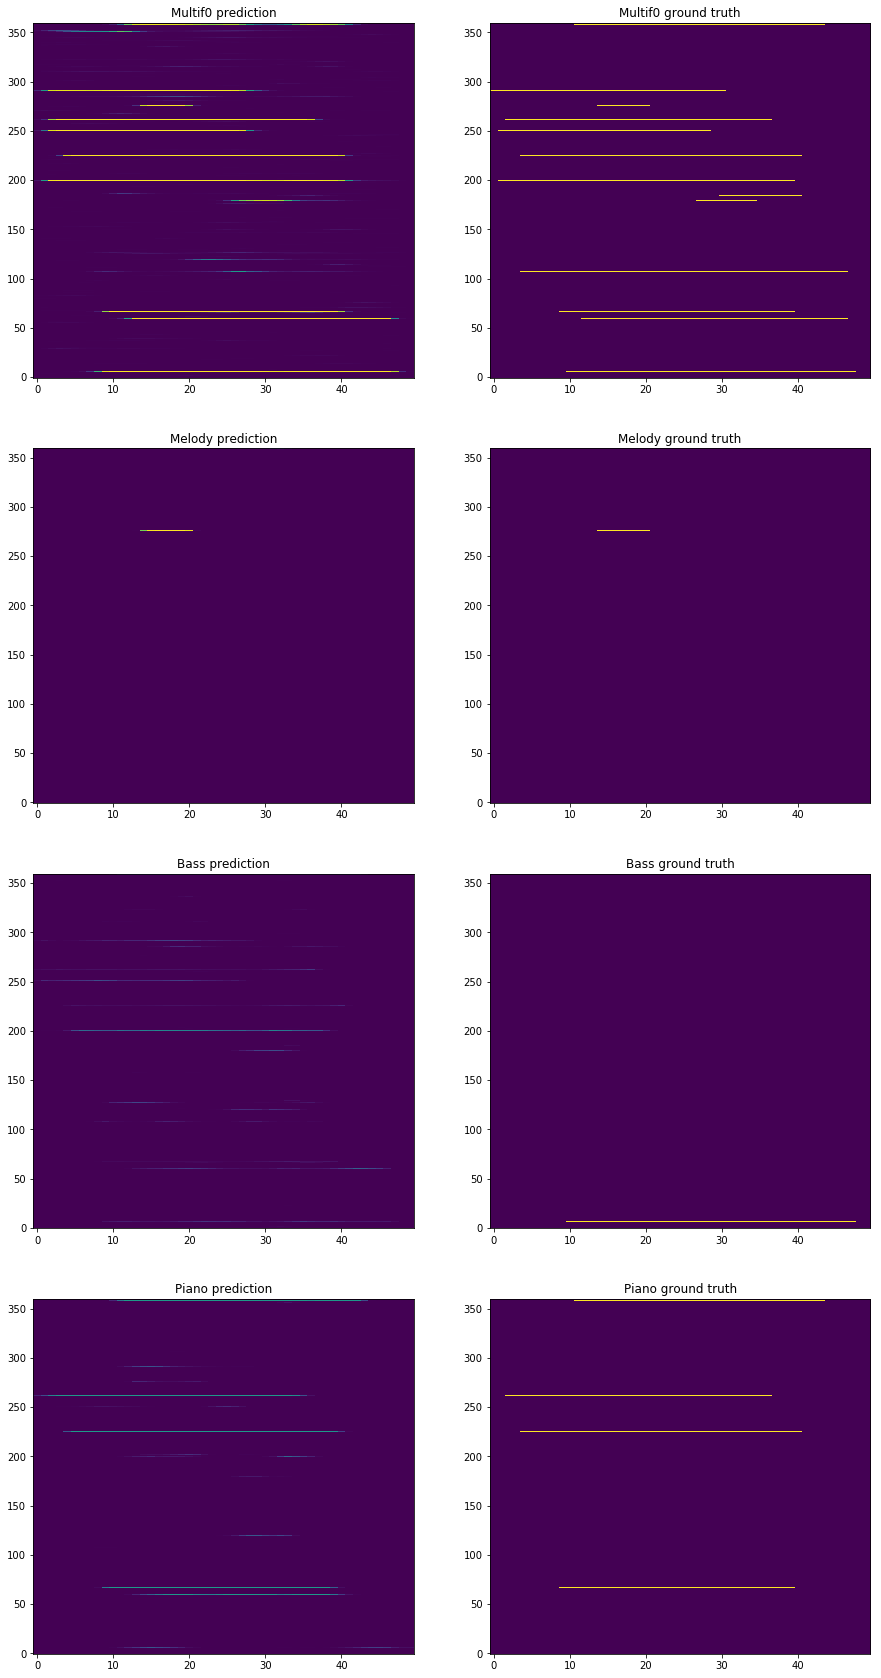

In [59]:
plt.figure(figsize=(15, 30))

plt.subplot(4, 2, 1)
plt.title("Multif0 prediction")
plt.imshow(Y_pred[0][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 2)
plt.title("Multif0 ground truth")
plt.imshow(Y_true['multif0'][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 3)
plt.title("Melody prediction")
plt.imshow(Y_pred[1][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 4)
plt.title("Melody ground truth")
plt.imshow(Y_true['melody'][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 5)
plt.title("Bass prediction")
plt.imshow(Y_pred[2][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 6)
plt.title("Bass ground truth")
plt.imshow(Y_true['bass'][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')


plt.subplot(4, 2, 7)
plt.title("Piano prediction")
plt.imshow(Y_pred[3][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 8)
plt.title("Piano ground truth")
plt.imshow(Y_true['piano'][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')
